In [14]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import tqdm


In [24]:
class FilteredImageDataset(Dataset):
    """Dataset that applies CV filters and thresholds to Boolean images."""
    
    def __init__(self, base_dataset: Dataset, threshold: float = 0.1):
        self.base_dataset = base_dataset
        self.threshold = threshold
        
        # Define all CV kernels as a list
        self.kernels = [
            # Edge detectors
            torch.tensor([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=torch.float32),  # Sobel X
            torch.tensor([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=torch.float32),  # Sobel Y
            torch.tensor([[-3, 0, 3], [-10, 0, 10], [-3, 0, 3]], dtype=torch.float32),  # Scharr X
            torch.tensor([[-3, -10, -3], [0, 0, 0], [3, 10, 3]], dtype=torch.float32),  # Scharr Y
            torch.tensor([[-1, -1, 0], [-1, 0, 1], [0, 1, 1]], dtype=torch.float32),  # Roberts Cross 1
            torch.tensor([[0, -1, -1], [1, 0, -1], [1, 1, 0]], dtype=torch.float32),  # Roberts Cross 2
            torch.tensor([[-1, -1, -1], [0, 0, 0], [1, 1, 1]], dtype=torch.float32),  # Prewitt X
            torch.tensor([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]], dtype=torch.float32),  # Prewitt Y
            
            # All-direction edge detectors
            torch.tensor([[0, 1, 0], [1, -4, 1], [0, 1, 0]], dtype=torch.float32),  # Laplacian 4-neighbor
            torch.tensor([[1, 1, 1], [1, -8, 1], [1, 1, 1]], dtype=torch.float32),  # Laplacian 8-neighbor
            
            # Blob detector
            torch.tensor([[0, 0, -1, 0, 0], [0, -1, -2, -1, 0], [-1, -2, 16, -2, -1], 
                         [0, -1, -2, -1, 0], [0, 0, -1, 0, 0]], dtype=torch.float32),  # LoG
            
            # Ridge/line detectors
            torch.tensor([[-1, -1, -1], [2, 2, 2], [-1, -1, -1]], dtype=torch.float32),  # Horizontal line
            torch.tensor([[-1, 2, -1], [-1, 2, -1], [-1, 2, -1]], dtype=torch.float32),  # Vertical line
            
            # High-pass filter
            torch.tensor([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]], dtype=torch.float32),  # Sharpen/High-pass
        ]
        
        # Add dimensions for conv2d: [out_channels, in_channels, H, W]
        self.kernels = [k.unsqueeze(0).unsqueeze(0) for k in self.kernels]

        # Precompute padding sizes
        self.paddings = [k.shape[-1] // 2 for k in self.kernels]

    def apply_filter(self, img: torch.Tensor, kernel: torch.Tensor, padding: int) -> torch.Tensor:
        """Apply convolution filter and threshold to Boolean."""
        
        # Apply convolution
        filtered = F.conv2d(img, kernel, padding=padding)

        # Normalize and threshold to Boolean
        filtered = torch.abs(filtered)
        filtered = filtered / (filtered.max() + 1e-8)
        boolean_img = (filtered > self.threshold).float().squeeze()
        
        return boolean_img
    
    def __getitem__(self, idx: int) -> tuple[torch.Tensor, int]:
        img, label = self.base_dataset[idx]

        # Convert to grayscale if RGB
        if img.shape[0] == 3:
            img = 0.299 * img[0] + 0.587 * img[1] + 0.114 * img[2]
            img = img.unsqueeze(0)
        else:
            img = img.unsqueeze(0)

        # Apply all filters
        filtered_outputs = [self.apply_filter(img, kernel, padding) for kernel, padding in zip(self.kernels, self.paddings)]
        
        # Stack into N-channel output
        filtered_img = torch.stack(filtered_outputs)
        
        return filtered_img, label
    
    def __len__(self) -> int:
        return len(self.base_dataset)  # type: ignore


In [27]:
cifar10 = False

# Example usage with CIFAR-10
if __name__ == "__main__":
    # Load CIFAR-10
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])
    
    if cifar10:
        cifar_train = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
        cifar_test = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
    else:
        cifar_train = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
        cifar_test = datasets.CIFAR100(root="./data", train=False, download=True, transform=transform)

    # Create filtered dataset
    filtered_dataset_train = FilteredImageDataset(cifar_train, threshold=0.2)
    filtered_dataset_test = FilteredImageDataset(cifar_test, threshold=0.2)
    
    # Create dataloader
    train_dataloader = DataLoader(filtered_dataset_train, batch_size=32, shuffle=True, num_workers=4)
    test_dataloader = DataLoader(filtered_dataset_test, batch_size=32, shuffle=False, num_workers=4)
    
    # Test
    for batch_imgs, batch_labels in test_dataloader:
        print(f"Batch shape: {batch_imgs.shape}")  # [32, 14, 32, 32]
        print(f"Labels shape: {batch_labels.shape}")  # [32]
        print(f"Values are Boolean: {torch.all((batch_imgs == 0) | (batch_imgs == 1))}")
        

        break

Batch shape: torch.Size([32, 14, 32, 32])
Labels shape: torch.Size([32])
Values are Boolean: True


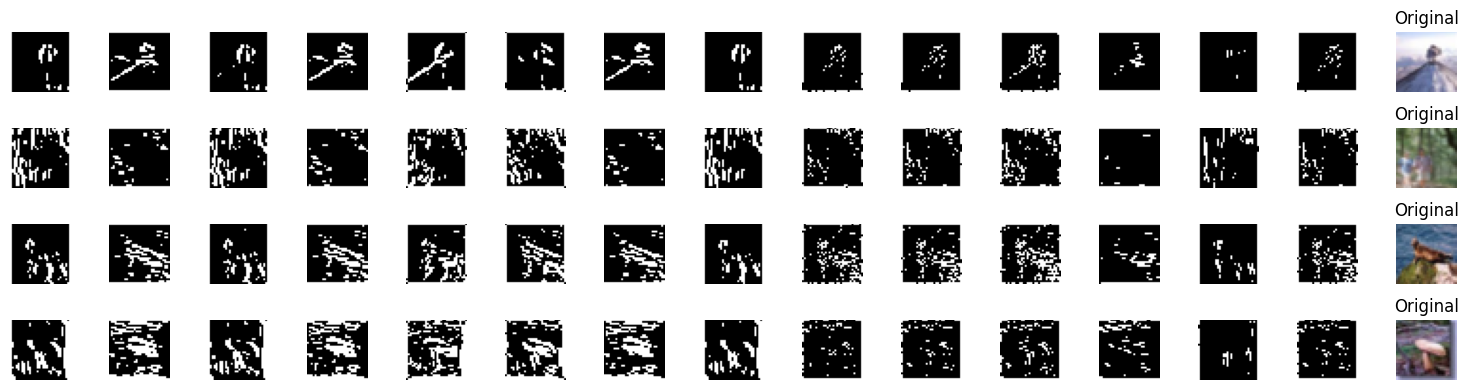

In [28]:
# Plot the first four images' 14 channels and their original
fig, axes = plt.subplots(4, 15, figsize=(15, 4))
for i in range(4):
    img, label = filtered_dataset_test[i]
    for j in range(img.shape[0]):
        axes[i, j].imshow(img[j], cmap='gray')
        axes[i, j].axis('off')
    # Original image
    orig_img, _ = cifar_test[i]
    orig_img = np.transpose(orig_img.numpy(), (1, 2, 0))
    axes[i, -1].imshow(orig_img)
    axes[i, -1].axis('off')
    axes[i, -1].set_title('Original')
plt.tight_layout()
plt.show()

In [33]:
class SimpleCNN(nn.Module):
    def __init__(self, cifar10: bool = True):
        super(SimpleCNN, self).__init__()
        self.conv1 = torch.nn.Conv2d(14, 32, kernel_size=3, padding=1)
        self.conv2 = torch.nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.flatten_size = 64 * 8 * 8
        if cifar10:
            self.fc1 = torch.nn.Linear(self.flatten_size, 128)
            self.fc2 = torch.nn.Linear(128, 10)
        else:
            self.fc1 = torch.nn.Linear(self.flatten_size, 256)
            self.fc2 = torch.nn.Linear(256, 100)
        self.pool = torch.nn.MaxPool2d(2, 2)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, self.flatten_size)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = SimpleCNN(cifar10=cifar10)
if torch.cuda.is_available():
    model.cuda()

def evaluate(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in tqdm.tqdm(dataloader, desc="Evaluating", total=len(dataloader)):
            if torch.cuda.is_available():
                inputs, labels = inputs.cuda(), labels.cuda()
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f"Accuracy: {accuracy:.2f}%")
    return accuracy

def train(model, train_dataloader, test_dataloader, epochs=5):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        running_correct = 0
        running_total = 0
        for i, (inputs, labels) in tqdm.tqdm(enumerate(train_dataloader), desc="Training", total=len(train_dataloader)):
            if torch.cuda.is_available():
                inputs, labels = inputs.cuda(), labels.cuda()
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs.data, 1)
            running_total += labels.size(0)
            running_correct += (predicted == labels).sum().item()
            
            running_loss += loss.item()
            if i % 250 == 249:  # Print every 249 mini-batches
                print(f"[{epoch + 1}, {i + 1}] loss: {running_loss / 250:.3f} accuracy: {100 * running_correct / running_total:.2f}%")
                running_loss = 0.0
                running_correct = 0
                running_total = 0
        evaluate(model, test_dataloader)
    print("Finished Training")

train(model, train_dataloader, test_dataloader, epochs=2)

Training:  17%|█▋        | 258/1563 [00:08<00:27, 47.93it/s]

[1, 250] loss: 4.482 accuracy: 2.73%


Training:  33%|███▎      | 511/1563 [00:12<00:18, 56.52it/s]

[1, 500] loss: 4.089 accuracy: 9.54%


Training:  48%|████▊     | 757/1563 [00:17<00:14, 56.79it/s]

[1, 750] loss: 3.830 accuracy: 12.80%


Training:  65%|██████▍   | 1010/1563 [00:21<00:09, 57.56it/s]

[1, 1000] loss: 3.663 accuracy: 15.84%


Training:  80%|████████  | 1256/1563 [00:26<00:05, 56.23it/s]

[1, 1250] loss: 3.523 accuracy: 17.96%


Training:  96%|█████████▋| 1508/1563 [00:30<00:01, 54.68it/s]

[1, 1500] loss: 3.411 accuracy: 19.74%


Evaluating: 100%|██████████| 313/313 [00:03<00:00, 84.04it/s]

Accuracy: 20.99%



Training:  16%|█▋        | 255/1563 [00:04<00:24, 52.52it/s]

[2, 250] loss: 3.213 accuracy: 22.69%


Training:  32%|███▏      | 507/1563 [00:09<00:19, 54.35it/s]

[2, 500] loss: 3.179 accuracy: 23.80%


Training:  49%|████▊     | 759/1563 [00:14<00:14, 53.95it/s]

[2, 750] loss: 3.127 accuracy: 24.82%


Training:  64%|██████▍   | 1005/1563 [00:18<00:10, 54.21it/s]

[2, 1000] loss: 3.128 accuracy: 25.26%


Training:  80%|████████  | 1257/1563 [00:23<00:05, 52.60it/s]

[2, 1250] loss: 3.093 accuracy: 25.02%


Training:  97%|█████████▋| 1509/1563 [00:28<00:01, 53.01it/s]

[2, 1500] loss: 3.082 accuracy: 26.48%


Evaluating: 100%|██████████| 313/313 [00:03<00:00, 80.08it/s]

Accuracy: 24.61%
Finished Training
